# Introduction

This notebook contains all the code used for the experiments in our submission, **Graph-guided Sparse Learning via Boolean Relaxation**, to ICML 2025.

In [119]:
import numpy as np
import scipy.io as sio
from scipy.linalg import toeplitz
from scipy.stats import multivariate_normal
import time
import random
from scipy.linalg import block_diag
from sklearn.metrics import precision_recall_curve, auc
import scipy.stats
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import random
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
from collections import defaultdict

import sys
import random
import itertools
import os
import matlab.engine
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, ElasticNetCV, Ridge
from scipy.sparse import csgraph

# **Section 1: Random Ensemble Generation**

In this section, we define a class `RandomEnsemble` to generate **random ensembles** as described in our paper. This class constructs synthetic datasets that incorporate structured sparsity through a predefined graph while ensuring realistic noise conditions.

## **1.1 Parameters for Random Ensemble Generation**

The `RandomEnsemble` class requires the following parameters to define a random ensemble:

### **Dataset Parameters**
- **`n`**: Number of samples.
- **`d`**: Number of features.
- **`k`**: Number of selected (nonzero) features.

### **Cluster Structure**
- **`h_total`**: Total number of clusters; we set `h_total=2` in our experiments.
- **`h_selected`**: Number of clusters containing selected features; we set `h_selected=1`.
- **`h_rest`**: Number of clusters containing the remaining features; we set `h_rest=1`.

### **Graph Parameters**
- **`p`**: Probability of edges forming between nodes within the same cluster.
- **`q`**: Probability of edges forming between nodes from different clusters.

### **Noise Control**
- **`gamma`**: Standard deviation of the noise in the response variable.

### **Replication Control**
- **`num_replications`**: Number of times each ensemble configuration is generated.

By tuning these parameters, we control the structure and randomness of the synthetic datasets while maintaining consistency across multiple replications.

---

## **1.2 The `RandomEnsemble` Class**
The `RandomEnsemble` class implements the random ensemble generation process as follows:

1. **Feature Clustering**: Partitions the features into `h_selected` clusters for selected features and `h_rest` clusters for non-selected features.
2. **Graph Construction**: Builds a probabilistic graph that encodes feature relationships using parameters `p` and `q`.
3. **Weight Vector Generation**: Assigns weights to selected features while maintaining sparsity.
4. **Synthetic Data Creation**: Generates a design matrix `X` with Gaussian-distributed entries.
5. **Response Variable Computation**: Defines the target variable `y` with added noise.

The generated ensembles provide a controlled environment to evaluate the performance of **graph-guided sparse learning** methods.

---

## **1.3 Variants of the `RandomEnsemble` Class**
To accommodate different experimental setups, we introduce **variants** of the `RandomEnsemble` class:

- **`RandomEnsembleWeight`**: Introduces slight variations in weights within the same cluster to simulate real-world deviations.
- **`RandomEnsembleCorrelation`**: Injects correlations between selected and non-selected features, adding complexity to feature selection.
- **`RandomEnsembleCorrelationWeight`**: Combines weight variations and feature correlations to create the most challenging scenarios.

Each variant extends the base `RandomEnsemble` class, modifying weight assignment and feature relationships while preserving the overall structure.

In [158]:
class RandomEnsemble:
    def __init__(self, n, d, k, h_total, h_selected, h_rest, gamma, 
                 p=0.95, q=0.01, 
                 options=None, num_replications=20,
                 datafile=f'./code_fgfl_aaai14/data_gfl/',
                 resultfile='./code_fgfl_aaai14/result_gfl/',
                 models=None):
        assert h_total == h_selected + h_rest, "h_total should be equal to h_selected + h_rest"
        self.n = n
        self.d = d
        self.k = k
        self.h_total = h_total
        self.h_selected = h_selected
        self.h_rest = h_rest
        self.gamma = gamma
        self.p = p
        self.q = q
        self.options = options if options else {'maxIter': 500, 'verbose': 0, 'SPGiters': 100}
        self.num_replications = num_replications
        self.datafile = os.path.join(os.path.abspath(datafile), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}')
        self.resultfile = os.path.join(os.path.abspath(resultfile), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}') # matlab does not like relative path
        self.best_rho1 = 0.5
        self.best_rho2 = 0.5
        self.best_mu = 1.0
        # self.best_rho = np.sqrt(self.n) * 6.8
        self.best_rho = np.sqrt(self.n)
        self.datafile_pqn = os.path.join(os.path.abspath('./PQN/data/'), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}')
        self.resultfile_pqn = os.path.join(os.path.abspath('./PQN/result/'), f'{n}_{d}_{k}_{h_total}_{h_selected}_{h_rest}_{gamma}_{p}_{q}')
        self._init(self.datafile, self.resultfile)
        self._init(self.datafile_pqn, self.resultfile_pqn)
        self.models = models

    
    def _init(self, datafile, resultfile):
        if not os.path.exists(datafile):
            os.makedirs(datafile)
        if not os.path.exists(resultfile):
            os.makedirs(resultfile)

    def _random_partition(self):
        # partition the first k nodes into h_selected groups and the rest into h_rest groups
        assert self.h_selected <= self.k, "h_selected should be less than k"
        assert self.h_rest <= self.d - self.k, "h_rest should be less d-k"
        if self.k % self.h_selected != 0 or (self.d - self.k) % self.h_rest != 0:
            break_points = np.sort(random.sample(range(1, self.k), self.h_selected-1))
            break_points_rest = np.sort(random.sample(range(self.k+1, self.d), self.h_rest-1))
        else: # evenly divide the nodes
            break_points = np.arange(self.k // self.h_selected, self.k, self.k // self.h_selected)
            break_points_rest = np.arange(self.k + (self.d - self.k) // self.h_rest, self.d, (self.d - self.k) // self.h_rest)
            
        return break_points, break_points_rest
    
    def _generate_clusters(self):
        if self.h_selected == 1 and self.h_rest == 1:
            clusters = [np.arange(self.k)]
            clusters.append(np.arange(self.k, self.d))
        else:
            break_points, break_points_rest = self._random_partition()
            clusters = []
            clusters.append(np.arange(break_points[0])) # first selected cluster
            for i in range(1, self.h_selected-1):
                clusters.append(np.arange(break_points[i-1], break_points[i]))
            clusters.append(np.arange(break_points[-1], self.k)) # last selected cluster

            clusters.append(np.arange(self.k, break_points_rest[0])) # first rest cluster
            for i in range(1, self.h_rest-1):
                clusters.append(np.arange(break_points_rest[i-1], break_points_rest[i]))
            clusters.append(np.arange(break_points_rest[-1], self.d))

        return clusters

    def _generate_graph(self):
        # here we generate the adjacency matrix and laplacian of the graph
        clusters = self._generate_clusters()

        A = sp.lil_matrix((self.d, self.d))
        
        # generate thr inner cluster connections
        for cluster in clusters:
            cluster_size = len(cluster)
            block = (np.random.rand(cluster_size, cluster_size) < self.p).astype(int)
            np.fill_diagonal(block, 0) # no self-loop
            block = np.triu(block) + np.triu(block, 1).T # make it symmetric
            for i, node_i in enumerate(cluster):
                for j, node_j in enumerate(cluster):
                    A[node_i, node_j] = block[i, j]

        # generate the connections between clusters
        for i in range(self.h_total):
            for j in range(i+1, self.h_total):
                cluster_i = clusters[i]
                cluster_j = clusters[j]
                block = (np.random.rand(len(cluster_i), len(cluster_j)) < self.q).astype(int)
                for m, node_i in enumerate(cluster_i):
                    for n, node_j in enumerate(cluster_j):
                        A[node_i, node_j] = block[m, n]
                        A[node_j, node_i] = block[m, n]

        # TODO: check if the graph is connected and make it connected if not 
        # (optional, maybe not necessary)
        D = sp.diags(np.ravel(A.sum(axis=1)))
        L = D - A
        return L, clusters, A
    
    def _visualize_graph(self, A):
        # if we want to visualize the graph, we need to change it to array rather than sparse matrix
        A_arr = A.toarray()
        plt.figure(figsize=(8, 8))
        plt.title('Adjacency matrix')
        plt.spy(A_arr)
        plt.axis('off')
        plt.show()

    def _generate_w(self, clusters):
        w = np.zeros(self.d)
        for i in range(self.h_selected):
            cluster_sign = np.random.choice([-1, 1])
            cluster_weight = cluster_sign * (1 / np.sqrt(self.k)) # TODO: make more choice other than 1/sqrt(k)
            for node in clusters[i]:
                w[node] = cluster_weight
        # w = w[:, np.newaxis]
        return w

    def _generate_X(self):
        # X = np.random.normal(0, 1, (self.n, self.d))
        mean = np.zeros(self.d)
        cov = np.eye(self.d)
        X = np.random.multivariate_normal(mean, cov, self.n)
        return X
    
    def _generate_y(self, X, w):
        signal = X @ w
        noise = np.random.normal(0, self.gamma, signal.shape)
        y = signal + noise
        SNR = self._compute_snr(signal, noise)
        if 0: # TODO: add a debug/verbose flag
            print(f'SNR: {SNR}')

        return y

    def _generate_data(self):
        L, clusters, A = self._generate_graph()
        if 0: # TODO: add a debug/verbose flag 
            self._visualize_graph(A)
        w = self._generate_w(clusters)
        X = self._generate_X()
        y = self._generate_y(X, w)
        return L, w, X, y, clusters, A


    def _compute_snr(self, signal, noise):  
        # in our case, the snr is 10*log10(1/gamma^2)
        signal = np.asarray(signal)
        noise = np.asarray(noise)

        signal_power = np.mean(signal ** 2)
        noise_power = np.mean(noise ** 2)
        
        snr = signal_power / noise_power
        snr_db = 10 * np.log10(snr)
        
        return snr_db
        
    def _max_degree(self, L):
        # find the maximum degree of the graph according to the laplacian matrix
        return np.max(np.diag(L.toarray()))
    
    def solver(self, model, X, y, clusters=None, L=None, A=None, i=None, rho=1, mu=1):
        if model == "Proximal":
            return self._solver_proximal(X, y, A, i)
        elif model == "Lasso":
            rho = np.sqrt(self.n) # TODO: check if this is the correct value
            return self._solver_gfl(X, y, L, i, rho, mu=0.0)
        elif model == "GFL_Matlab":
            return self._solver_gfl(X, y, L, i, rho=np.sqrt(self.n), mu=0.01)
        elif model == "Lasso_Sklearn":
            return self._solver_lasso_sklearn(X, y)
        elif model == "Adaptive_Grace":
            return self._solver_aGrace(X, y, A.toarray())
        else:
            raise ValueError("Model not supported")
    
    def _solver_lasso_sklearn(self, X, y):
        """
        Use sklearn's Lasso implementation to solve the Lasso problem.
        """
        alpha = 0.1
        lasso_model = Lasso(alpha=alpha, max_iter=10000)  # Lasso model with high max_iter
        lasso_model.fit(X, y)  # Fit the model
        u = lasso_model.coef_  # Get the coefficients
        # print(f"Lasso coefficients: {u}")
        return u
    
    def _solver_gfl(self, X, y, L, i, rho=None, mu=0.01, k=None):
        datafile_pqn = os.path.join(self.datafile_pqn, f'data_{i}.mat')
        resultfile_pqn = os.path.join(self.resultfile_pqn, f'result_{i}.mat')
        self._save_mat_pqn(X, y, L, datafile_pqn)
        if rho is None or mu is None:
            if i == 0:
                rho_values = [np.sqrt(self.n), 6.8 * np.sqrt(self.n)]
                mu_values = [0.01, 0.1, 1.0]
                self.best_rho, self.best_mu = self._cross_validation_gfl(X, y, L, rho_values, mu_values, k=k)
                print(f"Best rho: {self.best_rho}, Best mu: {self.best_mu}")
            rho = self.best_rho
            mu = self.best_mu

        self._call_gfl(datafile_pqn, resultfile_pqn, rho, mu, k)
        u, _ = self._read_result(resultfile_pqn)
        return u.flatten()
    
    def _save_mat_pqn(self, X, y, L, filename=None):
        # save the data to .mat file so that the matlab code of proxiaml can use it
        if y.ndim == 1:
            y = y[:, np.newaxis]
        data = {
            "X": X,
            "y": y,
            "L": L.toarray() if sp.issparse(L) else L,  # we store the adjacency matrix as dense matrix
        }
        sio.savemat(filename, data)

    
    def _call_gfl(self, datafile, resultfile, rho, mu, k=None):
        eng = matlab.engine.start_matlab()
        try:
            eng.cd(os.path.abspath('./PQN/'))
            eng.addpath(os.path.abspath('./PQN/'))
            eng.addpath(eng.genpath(os.path.abspath('./PQN/')))
            eng.addpath(eng.genpath(os.path.abspath('./PQN/minConF/')))
            if k:
                eng.gfl_pqn(datafile, resultfile, rho, mu, float(k), nargout=0)
            else:
                eng.gfl_pqn(datafile, resultfile, rho, mu, float(self.k), nargout=0)
        finally:
            eng.quit()
    
    def _save_result(self, u, filename):
        sio.savemat(filename, {'beta': u})
    
    def _call_proximal(self, datafile, resultfile, rho1, rho2):
        eng = matlab.engine.start_matlab()
        try:
            eng.cd(os.path.abspath('./code_fgfl_aaai14/'))
            eng.addpath(os.path.abspath('./code_fgfl_aaai14/GFL/'))
            eng.addpath(eng.genpath(os.path.abspath('./code_fgfl_aaai14/')))
            eng.gfl_proximal(datafile, resultfile, rho1, rho2, nargout=0)
        finally:
            eng.quit()

    def _cross_validation(self, X, y, A, rho1_values, rho2_values, k_folds=5):
        results = []
        n = self.n
        indices = np.arange(n)
        np.random.shuffle(indices)
        folds = np.array_split(indices, k_folds)
        datafile = os.path.join(self.datafile, 'data.mat') 
        resultfile = os.path.join(self.resultfile, 'result.mat')

        for rho1, rho2 in itertools.product(rho1_values, rho2_values):
            mse_list = []
            for fold in folds:
                train_indices = np.setdiff1d(indices, fold)
                test_indices = fold
                X_train, y_train = X[train_indices], y[train_indices]
                X_test, y_test = X[test_indices], y[test_indices]

                self._save_mat(X_train, y_train, A, datafile)
                self._call_proximal(datafile, resultfile, rho1, rho2)
                u, funcVal = self._read_result(resultfile)      
                mse = np.mean((X_test @ u - y_test) ** 2)
                mse_list.append(mse)

            avg = np.mean(mse_list)
            results.append((rho1, rho2, avg))

        best_rho1, best_rho2, _ = min(results, key=lambda x: x[2])
        return best_rho1, best_rho2
    
    def _cross_validation_gfl(self, X, y, L, rho_values, mu_values, k_folds=5, k=None):
        results = []
        n = self.n
        indices = np.arange(n)
        np.random.shuffle(indices)
        folds = np.array_split(indices, k_folds)
        datafile = os.path.join(self.datafile_pqn, 'data.mat')
        resultfile = os.path.join(self.resultfile_pqn, 'result.mat')

        for rho, mu in itertools.product(rho_values, mu_values):
            acc_list = []
            for fold in folds:
                train_indices = np.setdiff1d(indices, fold)
                test_indices = fold
                X_train, y_train = X[train_indices], y[train_indices]
                # X_test, y_test = X[test_indices], y[test_indices]
                self._save_mat_pqn(X_train, y_train, L, datafile)
                self._call_gfl(datafile, resultfile, rho, mu, k)
                u, _ = self._read_result(resultfile)
                u = u.flatten()
                acc_score = self.recovery_accuracy(u)
                acc_list.append(acc_score)
            
            avg = np.mean(acc_list)
            results.append((rho, mu, avg))
            print(f"rho: {rho}, mu: {mu}, acc: {avg}")
    
        best_rho, best_mu, _ = max(results, key=lambda x: x[2])
        # print(f"Best rho: {best_rho}, Best mu: {best_mu}")
        return best_rho, best_mu

    def _read_result(self, resultfile):
        result = sio.loadmat(resultfile)
        beta, funcVal = result['beta'], result['funcVal']
        return beta, funcVal
        
    def _solver_proximal(self, X, y, A, i):
        rho1_values = [0.1, 0.5, 1.0, 5.0]
        rho2_values = [0.1, 0.5, 1.0, 5.0]
        if i == 0: # we only do cross validation once and use the best rho1 and rho2 for the rest of the replications
            self.best_rho1, self.best_rho2 = self._cross_validation(X, y, A, rho1_values, rho2_values)
            print(f"Best rho1: {self.best_rho1}, Best rho2: {self.best_rho2}")

        datafile_name = os.path.join(self.datafile, f'data_{i}.mat')
        resultfile_name = os.path.join(self.resultfile, f'result_{i}.mat')
        self._save_mat(X, y, A, datafile_name)
        self._call_proximal(datafile_name, resultfile_name, self.best_rho1, self.best_rho2)
        u, funcVal = self._read_result(resultfile_name)
        return u.flatten() # the original return a vector with shape (d,1), will not work with recovery_accuracy
    
    def _adaptive_laplacian(self, L, beta_tilde):
        """Modify the Laplacian matrix to incorporate sign adjustments."""
        sign_beta = np.sign(beta_tilde)
        L_star = L * (sign_beta[:, None] @ sign_beta[None, :])
        return L_star
    
    def _soft_thresholding(self, z, gamma):
        return np.sign(z) * max(abs(z) - gamma, 0)
    

    def _solver_aGrace(self, X, y, W, lambda1=1.0, lambda2=1.0, max_iter=1000, tol=1e-4):
        # Standardize X and center y
        n, p = X.shape
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)
        X_std[X_std == 0] = 1  # avoid division by zero
        X = (X - X_mean) / X_std
        y_mean = y.mean()
        y = y - y_mean

        # Compute initial estimate beta_tilde
        if p < n:
            lr = LinearRegression(fit_intercept=False)
            lr.fit(X, y)
            beta_tilde = lr.coef_
        else:
            enet = ElasticNetCV(l1_ratio=0.5, fit_intercept=False, cv=5, max_iter=10000)
            enet.fit(X, y)
            beta_tilde = enet.coef_

        # Construct modified Laplacian matrix Lstar
        d = W.sum(axis=1).A1 if hasattr(W, 'A1') else W.sum(axis=1)  # handle sparse matrices
        Lstar = np.zeros((p, p))
        rows, cols = W.nonzero()
        for i in range(len(rows)):
            u, v = rows[i], cols[i]
            if u >= v:
                continue  # process each edge once
            if d[u] == 0 or d[v] == 0:
                Lstar[u, v] = Lstar[v, u] = 0
            else:
                sign_u = np.sign(beta_tilde[u]) if beta_tilde[u] != 0 else 0
                sign_v = np.sign(beta_tilde[v]) if beta_tilde[v] != 0 else 0
                weight = W[u, v] if isinstance(W, np.ndarray) else W.data[i]
                Lstar_uv = -sign_u * sign_v * weight / np.sqrt(d[u] * d[v])
                Lstar[u, v] = Lstar_uv
                Lstar[v, u] = Lstar_uv
        np.fill_diagonal(Lstar, 1 * (d > 0))  # set diagonal to 1 if degree > 0

        # Precompute adjacency list
        adjacency_list = [[] for _ in range(p)]
        for u, v in zip(rows, cols):
            if u != v:
                adjacency_list[u].append(v)

        # Initialize beta and residual
        beta = np.zeros(p)
        residual = y.copy()
        prev_beta = np.inf * np.ones(p)
        iter = 0

        # Coordinate descent
        while iter < max_iter and np.linalg.norm(beta - prev_beta) > tol:
            prev_beta = beta.copy()
            for u in range(p):
                xu = X[:, u]
                current_beta_u = beta[u]

                # Compute xuTr and neighbor_sum
                xuTr = xu @ residual
                xuTr_plus = xuTr + n * current_beta_u  # since xu.T @ xu = n

                neighbor_sum = 0
                for v in adjacency_list[u]:
                    neighbor_sum += Lstar[u, v] * beta[v]

                # Update beta_u
                z = (xuTr_plus - lambda2 * neighbor_sum) / (n + lambda2)
                threshold = lambda1 / (2 * (n + lambda2))
                beta_u_new = np.sign(z) * max(abs(z) - threshold, 0)

                # Update residual and beta
                delta = beta_u_new - current_beta_u
                residual -= xu * delta
                beta[u] = beta_u_new
            iter += 1
        return beta

    def recovery_accuracy(self, u):
        # evaluate the support recovery accuracy
        # we take top k for u
        selected_features_true = np.arange(self.k)
        selected_features_pred = np.argsort(np.abs(u))[-self.k:] # take absolute value for proximal method
        correct_pred = np.intersect1d(selected_features_true, selected_features_pred)
        accuracy = len(correct_pred) / self.k
        return accuracy
    
    def _save_mat(self, X, y, A, filename=None):
        # save the data to .mat file so that the matlab code of proxiaml can use it
        if y.ndim == 1:
            y = y[:, np.newaxis]
        data = {
            "X": X,
            "y": y,
            "AdjMat": A.toarray() if sp.issparse(A) else A,  # we store the adjacency matrix as dense matrix
        }
        sio.savemat(filename, data)

    def _report(self, model_accuracy):
        for model, accuracy in model_accuracy.items():
            avg_accuracy = np.mean(accuracy)
            std_accuracy = np.std(accuracy)
            print(f"Model: {model}, Avg. Accuracy: {avg_accuracy}, Std. Accuracy: {std_accuracy}")

    def runtime(self):
        """
        Measures runtime for different methods and generates a formatted table.
        """
        if self.models is None:
            models = ["GFL_Matlab", "Lasso", "Proximal", "Lasso_Sklearn", "Adaptive_Grace"]
        else:
            models = self.models
        
        runtime_results = {model: [] for model in models}  # Store runtimes

        for i in range(self.num_replications):
            L, w, X, y, clusters, A = self._generate_data()
            
            for model in models:
                print(f"Running {model} on replication {i+1}/{self.num_replications}...")

                start_time = time.time()  # Start timer
                u = self.solver(model, X, y, clusters, L, A, i)  # Solve
                end_time = time.time()  # End timer

                runtime_results[model].append(end_time - start_time)  # Store runtime
            
            print(f"Replication {i+1} completed.")

        # Compute mean and standard deviation for each method
        runtime_summary = {model: (np.mean(times), np.std(times)) for model, times in runtime_results.items()}
        return runtime_summary

    def out_of_sample(self, ):
        k_values = np.arange(30, 110, 10)
        mse_results = defaultdict(list)
        for i in range(self.num_replications):
            print(f"Running replication {i+1}/{self.num_replications}...")
            # Generate synthetic dataset
            L, w, X, y, clusters, A = self._generate_data()
            for k in k_values:
                # Solve the original problem with given k
                u = self._solver_gfl(X, y, L, i, rho=np.sqrt(self.n), mu=0.01,k=k)  

                # Select top k features
                selected_features = np.argsort(np.abs(u))[-k:]

                # Solve the subproblem with selected features
                X_sub = X[:, selected_features]
                linear_model = Lasso(alpha=0.5)
                linear_model.fit(X_sub, y)
                y_pred = linear_model.predict(X_sub)

                # Compute MSE
                mse = np.mean((y - y_pred) ** 2)
                mse_results[k].append(mse)

                print(f"Replication {i+1} with value {k} completed.")

        return mse_results


    def main(self):
        # models = ["Proximal", "Lasso", "GroupLasso", "GeneralizedFusedLasso"]
        # models = ["GeneralizedFusedLasso", "Proximal"]
        if self.models is None:
            models = ["GFL_Matlab", "Lasso", "Proximal", "Lasso_Sklearn", "Adaptive_Grace"]
        else:
            models = self.models
        # models = ["Lasso_Sklearn"]
        model_accuracy = defaultdict(list)
        for i in range(self.num_replications):
            L, w, X, y, clusters, A = self._generate_data()
            for model in models:
                print(f"Synthetic dataset {i+1}: Running {model} model")
                u = self.solver(model, X, y, clusters, L, A, i)
                accuracy = self.recovery_accuracy(u)
                model_accuracy[model].append(accuracy)

        self._report(model_accuracy)
        return model_accuracy
    

class RandomEnsembleWeight(RandomEnsemble):
    def _generate_w(self, clusters):
        w = np.zeros(self.d)
        cluster_weights = []

        # Generate non-zero random weights for clusters
        for _ in range(self.h_selected):
            cluster_sign = np.random.choice([-1, 1])
            cluster_weight = cluster_sign * (1 / np.sqrt(self.k))
            cluster_weights.append(cluster_weight)

        # Generate zero weights for the rest of the clusters
        for _ in range(self.h_rest):
            cluster_weights.append(0)

        for i in range(self.h_total):
            for node in clusters[i]:
                w[node] = cluster_weights[i] + np.random.normal(0, 0.1* np.abs(cluster_weights[i]))  # we allow weights in the same cluster to be slightly different

        return w
    
class RandomEnsembleCorrelation(RandomEnsemble):
    def _generate_X(self):
        mean = np.zeros(self.d)
        cov = np.eye(self.d)
        # for the correlated case, we find some correlation between the selected features and non-selected features
        correlated_ratio = 0.3
        selected_features = np.arange(self.k)
        non_selected_features = np.arange(self.k, self.d)

        correlated_pairs = []
        selected_features_correlated = random.sample(list(selected_features), int(correlated_ratio * self.k))
        non_selected_features_correlated = random.sample(list(non_selected_features), int(correlated_ratio * self.k))
        for i in selected_features_correlated:
            for j in non_selected_features_correlated:
                correlated_pairs.append((i, j))
        
        for i, j in correlated_pairs:
            cov[i, j] = 0.9
            cov[j, i] = 0.9

        eigvals, eigvecs = np.linalg.eigh(cov)
        eigvals = np.maximum(eigvals, 0)  # Set negative eigenvalues to zero
        cov = eigvecs @ np.diag(eigvals) @ eigvecs.T

        X = np.random.multivariate_normal(mean, cov, self.n)
        return X
    
class RandomEnsembleCorrelationWeight(RandomEnsemble):
    def _generate_w(self, clusters):
        w = np.zeros(self.d)
        cluster_weights = []

        # Generate non-zero random weights for clusters
        for _ in range(self.h_selected):
            cluster_weight = (1 / np.sqrt(self.k))
            cluster_weights.append(cluster_weight)

        # Generate zero weights for the rest of the clusters
        for _ in range(self.h_rest):
            cluster_weights.append(0)

        for i in range(self.h_total):
            for node in clusters[i]:
                node_sign = np.random.choice([-1, 1])
                w[node] = node_sign * cluster_weights[i] + np.random.normal(0, 0.01)  # we allow weights in the same cluster to be slightly different

        return w
    
    def _generate_X(self):
        mean = np.zeros(self.d)
        cov = np.eye(self.d)
        # for the correlated case, we find some correlation between the selected features and non-selected features
        correlated_ratio = 0.3
        selected_features = np.arange(self.k)
        non_selected_features = np.arange(self.k, self.d)

        correlated_pairs = []
        selected_features_correlated = random.sample(list(selected_features), int(correlated_ratio * self.k))
        non_selected_features_correlated = random.sample(list(non_selected_features), int(correlated_ratio * self.k))
        for i in selected_features_correlated:
            for j in non_selected_features_correlated:
                correlated_pairs.append((i, j))
        
        for i, j in correlated_pairs:
            cov[i, j] = 0.9
            cov[j, i] = 0.9

        eigvals, eigvecs = np.linalg.eigh(cov)
        eigvals = np.maximum(eigvals, 0)  # Set negative eigenvalues to zero
        cov = eigvecs @ np.diag(eigvals) @ eigvecs.T

        X = np.random.multivariate_normal(mean, cov, self.n)
        return X


Below we provide the visualization of the example data we generate for each of the for experiment.

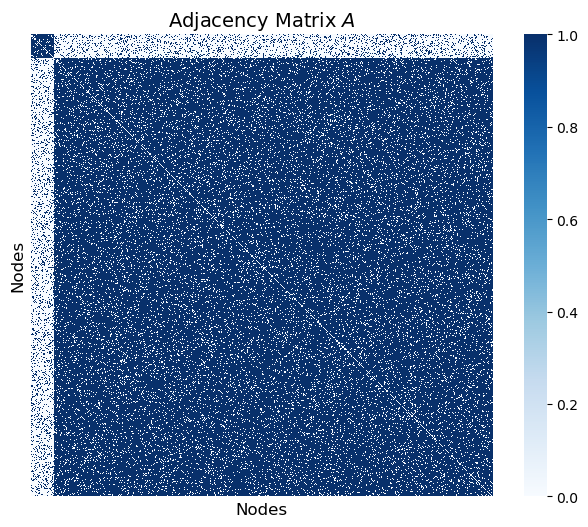

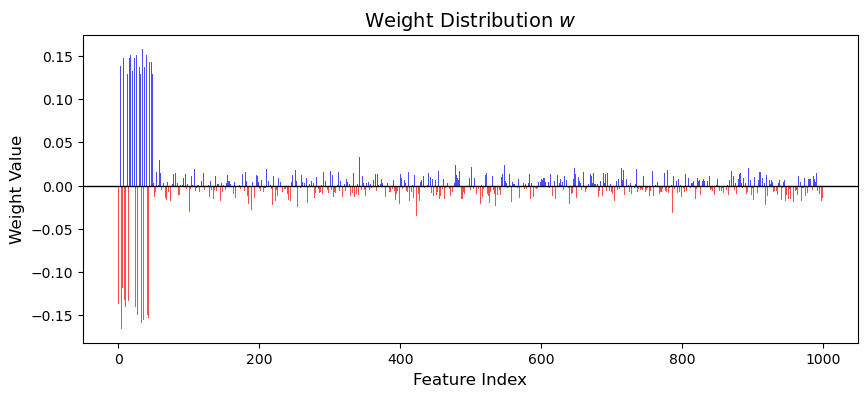

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate data
a = RandomEnsembleCorrelationWeight(n=50, d=1000, k=50,
                                    h_total=2, h_selected=1, h_rest=1,
                                    gamma=0.5, p=0.9, q=0.2,
                                    num_replications=10)

L, w, X, y, clusters, A = a._generate_data()

# Convert A to a dense matrix for visualization
A_dense = A.toarray()

# 🔹 Improved Adjacency Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(A_dense, cmap="Blues", cbar=True, square=True, xticklabels=False, yticklabels=False)
plt.title("Adjacency Matrix $A$", fontsize=14)
plt.xlabel("Nodes", fontsize=12)
plt.ylabel("Nodes", fontsize=12)
plt.show()

# 🔹 Improved Weight Distribution Visualization
plt.figure(figsize=(10, 4))
indices = np.arange(len(w))
colors = ['red' if val < 0 else 'blue' for val in w]  # Color-code positive and negative weights
plt.bar(indices, w, color=colors, alpha=0.7)
plt.axhline(0, color='black', linewidth=1)  # Reference line at 0
plt.xlabel("Feature Index", fontsize=12)
plt.ylabel("Weight Value", fontsize=12)
plt.title("Weight Distribution $w$", fontsize=14)
plt.show()


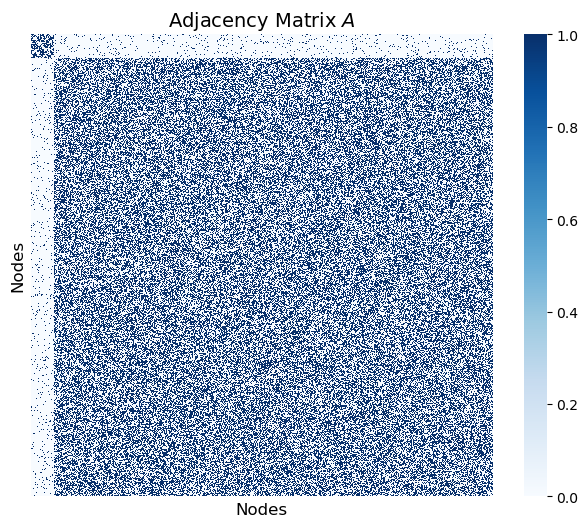

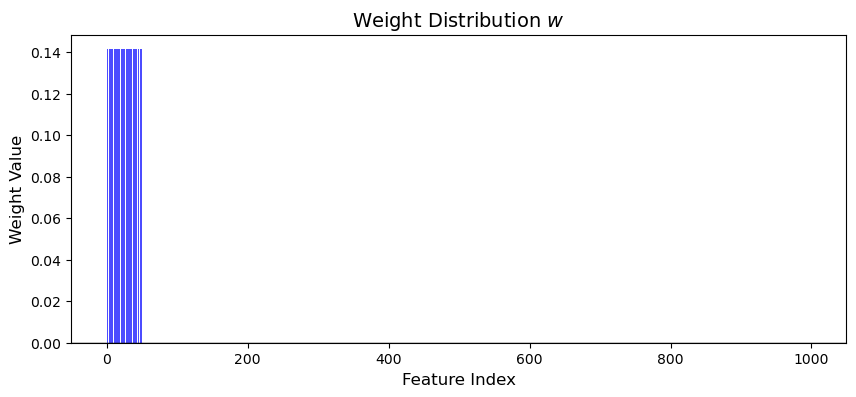

In [ ]:
a = RandomEnsembleCorrelation(n=50, d=1000, k=50,
                                    h_total=2, h_selected=1, h_rest=1,
                                    gamma=0.5, p=0.5, q=0.05,
                                    num_replications=10)

L, w, X, y, clusters, A = a._generate_data()

# Convert A to a dense matrix for visualization
A_dense = A.toarray()

# 🔹 Improved Adjacency Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(A_dense, cmap="Blues", cbar=True, square=True, xticklabels=False, yticklabels=False)
plt.title("Adjacency Matrix $A$", fontsize=14)
plt.xlabel("Nodes", fontsize=12)
plt.ylabel("Nodes", fontsize=12)
plt.show()

# 🔹 Improved Weight Distribution Visualization
plt.figure(figsize=(10, 4))
indices = np.arange(len(w))
colors = ['red' if val < 0 else 'blue' for val in w]  # Color-code positive and negative weights
plt.bar(indices, w, color=colors, alpha=0.7)
plt.axhline(0, color='black', linewidth=1)  # Reference line at 0
plt.xlabel("Feature Index", fontsize=12)
plt.ylabel("Weight Value", fontsize=12)
plt.title("Weight Distribution $w$", fontsize=14)
plt.show()


# **Section 2: Experiments**

In this section, we conduct **experiments** to evaluate the performance of different optimization methods on **graph-guided sparse learning**. We generate synthetic data using a **fixed set of parameters** and compare methods based on **top-k support recovery accuracy** and **out-of-sample Mean Squared Error (MSE)**.

For each parameter setting, we:
1. **Generate 100 random ensembles** to ensure statistical robustness.
2. **Run different optimization methods** on the generated data.
3. **Evaluate performance** based on:
   - **Top-k Support Recovery Accuracy**: Measures how well each method identifies the correct nonzero features.
   - **Out-of-Sample MSE**: Assesses prediction error on unseen data.

### **Hyperparameter Selection**
For methods requiring hyperparameters, we use **cross-validation** to select the best configuration before evaluating performance.

We evaluate the following **five optimization methods** for solving the sparse learning problem:

1. **Lasso**  
   A standard convex relaxation technique that enforces sparsity using an \( \ell_1 \)-norm penalty.

2. **Adaptive Grace**  
   A variant of the **Generalized Adaptive Elastic Net**, which incorporates graph-structured constraints into feature selection.

3. **Fast GFL (AAAI-2014)**  
   A **generalized fused lasso** method designed to incorporate graph structure into sparse learning.

4. **Boolean Lasso**  
   A sparsity-enforcing method that uses **Boolean constraints** to improve feature selection.

5. **Our Method: Boolean GFL**  
   Our proposed **Boolean Graph-Guided Sparse Learning** method, which combines Boolean relaxation techniques with graph-based constraints to improve structured sparsity recovery.


## Section 2.1: Out-of-sample MSE

In [ ]:
random_ensemble = RandomEnsembleCorrelation(n=600, d=1000, k=50, 
                                    h_total=2, h_selected=1, h_rest=1, 
                                    gamma=0.5, p=0.9, q=0.2, 
                                    num_replications=10)
ofs_mse = random_ensemble.out_of_sample()

In [145]:
random_ensemble = RandomEnsembleCorrelation(n=600, d=1000, k=50, 
                                    h_total=2, h_selected=1, h_rest=1, 
                                    gamma=0.5, p=0.9, q=0.2, 
                                    num_replications=10)
ofs_mse_1 = random_ensemble.out_of_sample()

Running replication 1/10...
Replication 1 with value 30 completed.
Replication 1 with value 40 completed.
Replication 1 with value 50 completed.
Replication 1 with value 60 completed.
Replication 1 with value 70 completed.
Replication 1 with value 80 completed.
Replication 1 with value 90 completed.
Replication 1 with value 100 completed.
Running replication 2/10...
Replication 2 with value 30 completed.
Replication 2 with value 40 completed.
Replication 2 with value 50 completed.
Replication 2 with value 60 completed.
Replication 2 with value 70 completed.
Replication 2 with value 80 completed.
Replication 2 with value 90 completed.
Replication 2 with value 100 completed.
Running replication 3/10...
Replication 3 with value 30 completed.
Replication 3 with value 40 completed.
Replication 3 with value 50 completed.
Replication 3 with value 60 completed.
Replication 3 with value 70 completed.
Replication 3 with value 80 completed.
Replication 3 with value 90 completed.
Replication 3 wit

In [ ]:
random_ensemble = RandomEnsembleCorrelation(n=600, d=1000, k=50, 
                                    h_total=2, h_selected=1, h_rest=1, 
                                    gamma=0.5, p=0.7, q=0.2, 
                                    num_replications=10)
ofs_mse_2 = random_ensemble.out_of_sample()

Running replication 1/10...
Replication 1 with value 30 completed.
Replication 1 with value 40 completed.
Replication 1 with value 50 completed.
Replication 1 with value 60 completed.
Replication 1 with value 70 completed.
Replication 1 with value 80 completed.
Replication 1 with value 90 completed.
Replication 1 with value 100 completed.
Running replication 2/10...
Replication 2 with value 30 completed.
Replication 2 with value 40 completed.
Replication 2 with value 50 completed.
Replication 2 with value 60 completed.
Replication 2 with value 70 completed.
Replication 2 with value 80 completed.
Replication 2 with value 90 completed.
Replication 2 with value 100 completed.
Running replication 3/10...
Replication 3 with value 30 completed.
Replication 3 with value 40 completed.
Replication 3 with value 50 completed.
Replication 3 with value 60 completed.
Replication 3 with value 70 completed.
Replication 3 with value 80 completed.
Replication 3 with value 90 completed.
Replication 3 wit

In [155]:
import numpy as np
import matplotlib.pyplot as plt

def plot_out_of_sample_mse(mse_results, true_k, i):
    """
    Plots out-of-sample MSE vs k with error bars.
    
    Parameters:
    - mse_results: Dictionary {k: [list of MSEs]} with results from `out_of_sample()`.
    - true_k: The actual number of contributing features (to mark with a vertical line).
    """
    
    plt.figure(figsize=(6, 5))
    
    k_vals = sorted(mse_results.keys())  # Get sorted k values
    mse_means = [np.mean(mse_results[k]) for k in k_vals]  # Mean MSE for each k
    mse_stds = [np.std(mse_results[k]) for k in k_vals]  # Standard deviation
    k_vals = [k for k in k_vals]
    
    # Plot MSE with error bars
    plt.errorbar(k_vals, mse_means, yerr=mse_stds, fmt='o-', capsize=4, linestyle='--', color='r', label="Estimated MSE")

    # Add vertical black line at true k
    plt.axvline(x=true_k, color='k', linestyle='-', linewidth=2, label="True k")

    # Labels and legend
    plt.xlabel(r'$k$', fontsize=14)
    plt.ylabel("Out of Sample MSE", fontsize=14)
    # plt.title(r'Estimate $k$ by Out-of-Sample MSE', fontsize=14)
    plt.legend()
    plt.grid(True)
    # save pdf 
    plt.savefig(f'out_of_sample_mse_{i}.pdf', bbox_inches='tight')
     # save png
    plt.show()

/var/folders/1z/cz7sgb1n2zz05wf6l692bzl00000gn/T/ipykernel_89287/2090226830.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(k_vals, mse_means, yerr=mse_stds, fmt='o-', capsize=4, linestyle='--', color='r', label="Estimated MSE")


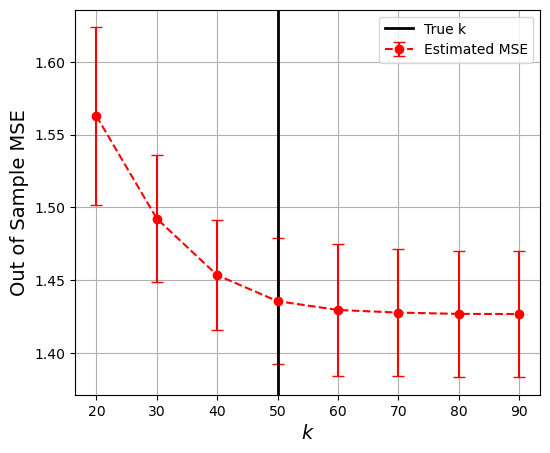

In [ ]:
plot_out_of_sample_mse(ofs_mse_1, 50)

/var/folders/1z/cz7sgb1n2zz05wf6l692bzl00000gn/T/ipykernel_89287/2090226830.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(k_vals, mse_means, yerr=mse_stds, fmt='o-', capsize=4, linestyle='--', color='r', label="Estimated MSE")


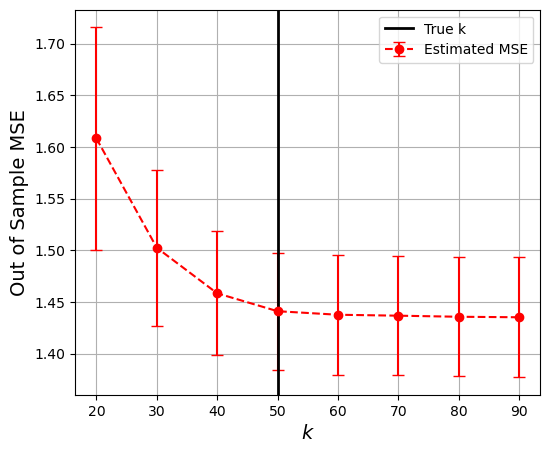

In [153]:
plot_out_of_sample_mse(ofs_mse_2, 50)

/var/folders/1z/cz7sgb1n2zz05wf6l692bzl00000gn/T/ipykernel_89287/2284176568.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(k_vals, mse_means, yerr=mse_stds, fmt='o-', capsize=4, linestyle='--', color='r', label="Estimated MSE")


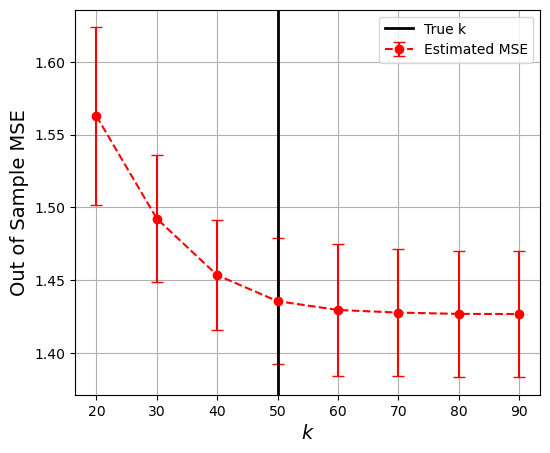

/var/folders/1z/cz7sgb1n2zz05wf6l692bzl00000gn/T/ipykernel_89287/2284176568.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(k_vals, mse_means, yerr=mse_stds, fmt='o-', capsize=4, linestyle='--', color='r', label="Estimated MSE")


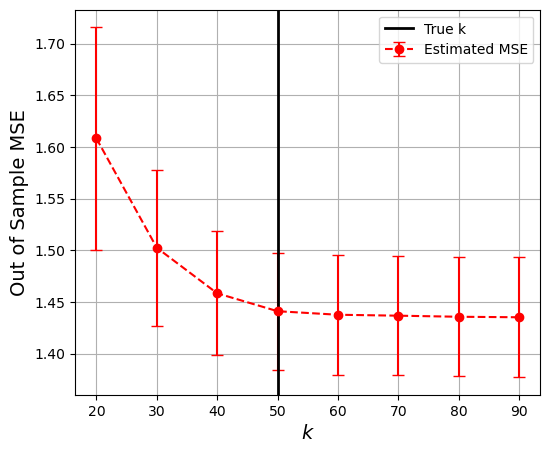

In [156]:
plot_out_of_sample_mse(ofs_mse_1, 50, 1)
plot_out_of_sample_mse(ofs_mse_2, 50, 2)

# Section 2.2 : Top-k Support Recovery Accuracy

In [31]:
accuracy_42 = []
sample_sizes = np.arange(50, 1000, 100)
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=2, h_selected=1, h_rest=1, 
                                     gamma=0.5, p=0.9, q=0.2,
                                     models=["Adaptive_Grace"], 
                                     num_replications=10)
    accuracy_42.append(random_ensemble.main())

Synthetic dataset 1: Running Adaptive_Grace model
Synthetic dataset 2: Running Adaptive_Grace model
Synthetic dataset 3: Running Adaptive_Grace model
Synthetic dataset 4: Running Adaptive_Grace model
Synthetic dataset 5: Running Adaptive_Grace model
Synthetic dataset 6: Running Adaptive_Grace model
Synthetic dataset 7: Running Adaptive_Grace model
Synthetic dataset 8: Running Adaptive_Grace model
Synthetic dataset 9: Running Adaptive_Grace model
Synthetic dataset 10: Running Adaptive_Grace model
Model: Adaptive_Grace, Avg. Accuracy: 0.20800000000000002, Std. Accuracy: 0.028565713714171402
Synthetic dataset 1: Running Adaptive_Grace model
Synthetic dataset 2: Running Adaptive_Grace model
Synthetic dataset 3: Running Adaptive_Grace model
Synthetic dataset 4: Running Adaptive_Grace model
Synthetic dataset 5: Running Adaptive_Grace model
Synthetic dataset 6: Running Adaptive_Grace model
Synthetic dataset 7: Running Adaptive_Grace model
Synthetic dataset 8: Running Adaptive_Grace model
Synt

In [32]:
accuracy_52 = []
sample_sizes = np.arange(50, 1000, 100)
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelationWeight(n=n, d=1000, k=50, 
                                     h_total=2, h_selected=1, h_rest=1, 
                                     gamma=0.5, p=0.9, q=0.2, 
                                     models=["Adaptive_Grace"],
                                     num_replications=10)
    accuracy_52.append(random_ensemble.main())

Synthetic dataset 1: Running Adaptive_Grace model
Synthetic dataset 2: Running Adaptive_Grace model
Synthetic dataset 3: Running Adaptive_Grace model
Synthetic dataset 4: Running Adaptive_Grace model
Synthetic dataset 5: Running Adaptive_Grace model
Synthetic dataset 6: Running Adaptive_Grace model
Synthetic dataset 7: Running Adaptive_Grace model
Synthetic dataset 8: Running Adaptive_Grace model
Synthetic dataset 9: Running Adaptive_Grace model
Synthetic dataset 10: Running Adaptive_Grace model
Model: Adaptive_Grace, Avg. Accuracy: 0.1, Std. Accuracy: 0.025298221281347035
Synthetic dataset 1: Running Adaptive_Grace model
Synthetic dataset 2: Running Adaptive_Grace model
Synthetic dataset 3: Running Adaptive_Grace model
Synthetic dataset 4: Running Adaptive_Grace model
Synthetic dataset 5: Running Adaptive_Grace model
Synthetic dataset 6: Running Adaptive_Grace model
Synthetic dataset 7: Running Adaptive_Grace model
Synthetic dataset 8: Running Adaptive_Grace model
Synthetic dataset 9:

In [38]:
# read the accuracies from the file
with open('accuracies.pkl', 'rb') as f:
    accuracys = pickle.load(f)

In [39]:
accuracy_41 = accuracys[-2]
accuracy_51 = accuracys[-1]

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

def analysis(accuracy, j=100):
    acc_1, acc_2, acc_3, acc_4, acc_5 = [], [], [], [], []
    ci_1, ci_2, ci_3, ci_4, ci_5 = [], [], [], [], []

    for i in range(len(accuracy)):
        n_1 = len(accuracy[i]['Proximal'])
        std_1 = np.std(accuracy[i]['Proximal'], ddof=1)  # Sample standard deviation
        sem_1 = std_1 / np.sqrt(n_1)  # Standard error
        ci_1.append(t.ppf(0.975, df=n_1-1) * sem_1)  # 95% CI using t-distribution
        acc_1.append(np.mean(accuracy[i]['Proximal']))

        n_2 = len(accuracy[i]['GFL_Matlab'])
        std_2 = np.std(accuracy[i]['GFL_Matlab'], ddof=1)
        sem_2 = std_2 / np.sqrt(n_2)
        ci_2.append(t.ppf(0.975, df=n_2-1) * sem_2)
        acc_2.append(np.mean(accuracy[i]['GFL_Matlab']))

        n_3 = len(accuracy[i]['Lasso'])
        std_3 = np.std(accuracy[i]['Lasso'], ddof=1)
        sem_3 = std_3 / np.sqrt(n_3)
        ci_3.append(t.ppf(0.975, df=n_3-1) * sem_3)
        acc_3.append(np.mean(accuracy[i]['Lasso']))

        n_4 = len(accuracy[i]['Lasso_Sklearn'])
        std_4 = np.std(accuracy[i]['Lasso_Sklearn'], ddof=1)
        sem_4 = std_4 / np.sqrt(n_4)
        ci_4.append(t.ppf(0.975, df=n_4-1) * sem_4)
        acc_4.append(np.mean(accuracy[i]['Lasso_Sklearn']))

        n_5 = len(accuracy[i]['Adaptive_Grace'])
        std_5 = np.std(accuracy[i]['Adaptive_Grace'], ddof=1)
        sem_5 = std_5 / np.sqrt(n_5)
        ci_5.append(t.ppf(0.975, df=n_5-1) * sem_5)
        acc_5.append(np.mean(accuracy[i]['Adaptive_Grace']))

    plt.figure(figsize=(8, 6))
    plt.errorbar(sample_sizes[:len(accuracy)], acc_1, yerr=ci_1, fmt='o-', label='Proximal', capsize=5)
    plt.errorbar(sample_sizes[:len(accuracy)], acc_2, yerr=ci_2, fmt='o-', label='Proposed', capsize=5)
    plt.errorbar(sample_sizes[:len(accuracy)], acc_3, yerr=ci_3, fmt='o-', label='BooleanLasso', capsize=5)
    plt.errorbar(sample_sizes[:len(accuracy)], acc_4, yerr=ci_4, fmt='o-', label='Lasso', capsize=5)
    plt.errorbar(sample_sizes[:len(accuracy)], acc_5, yerr=ci_5, fmt='o-', label='Adaptive_Grace', capsize=5)

    plt.xlabel('Sample Size')
    plt.ylabel('Accuracy of Support Recovery')
    # plt.title('Accuracy vs. Sample Size (95% CI)')
    plt.grid(True)
    plt.legend()
    
    pdf_filename = f"output_{j}.pdf"
    plt.savefig(pdf_filename, bbox_inches='tight')
    plt.show()


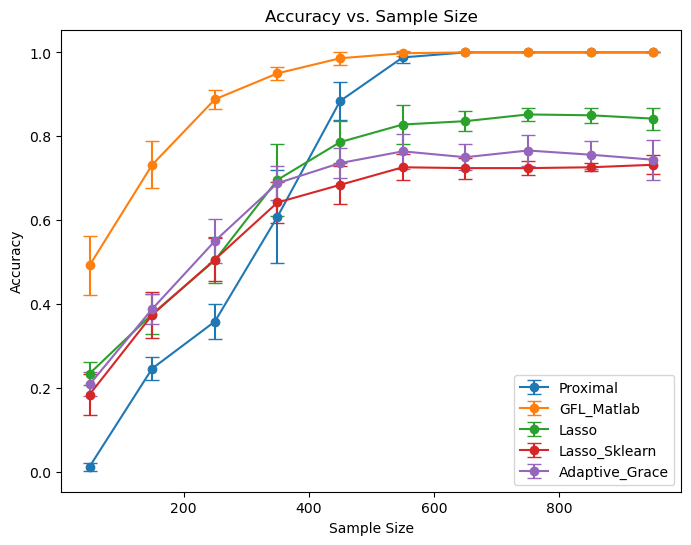

In [41]:
# add the results to the accuracys 41 and 51
for i in range(len(accuracy_41)):
    accuracy_41[i]['Adaptive_Grace'] = accuracy_42[i]['Adaptive_Grace']
for i in range(len(accuracy_51)):
    accuracy_51[i]['Adaptive_Grace'] = accuracy_52[i]['Adaptive_Grace']

    

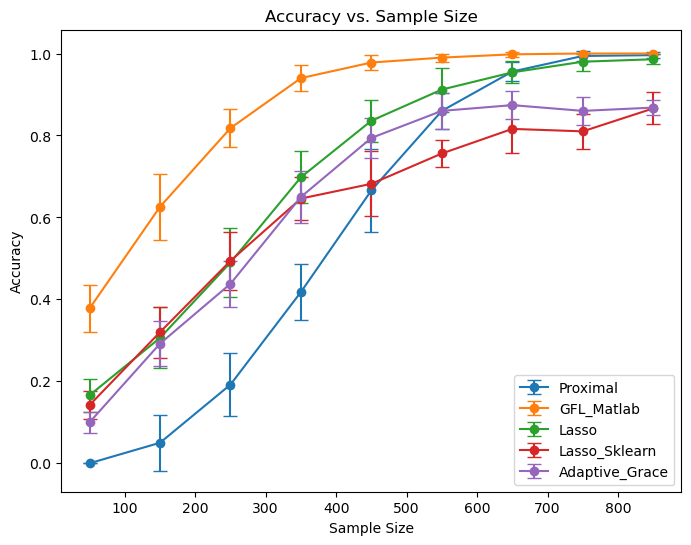

In [42]:
analysis(accuracy_51, 51)

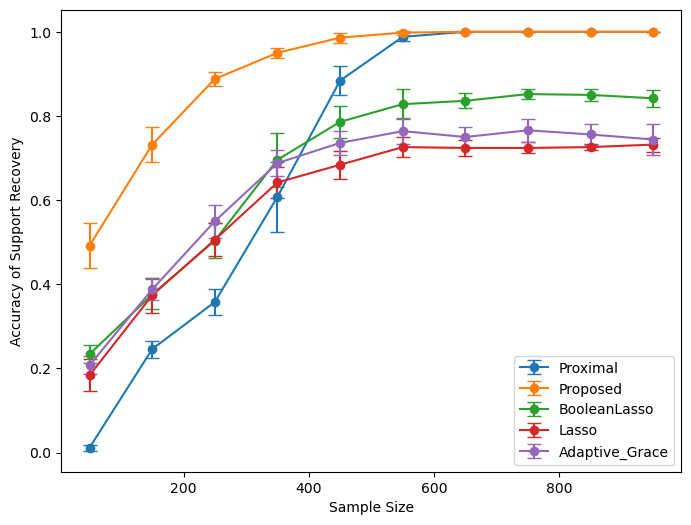

In [ ]:
analysis(accuracy_41, 41)

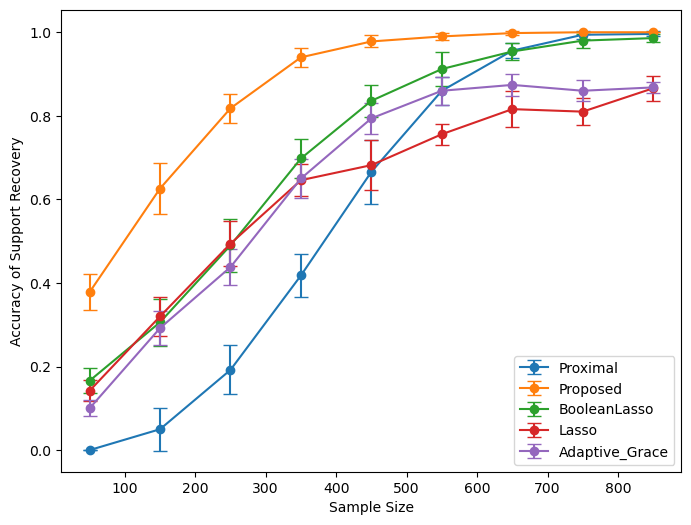

In [61]:
analysis(accuracy_51, 51)

In [160]:
sample_sizes = np.arange(50, 900, 100)
accuracy_77= []
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelation(n=n, d=1000, k=50, 
                                     h_total=2, h_selected=1, h_rest=1, 
                                     gamma=0.5, p=0.7, q=0.2, 
                                     num_replications=10)
    accuracy_77.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
5 7
5 7
5 7
5 7
5 7
5 7
5 7
5 7
5 7
3 5
3 5
4 6
4 6
3 5
4 6
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 1: Running Adaptive_Grace model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
11 13
11 13
11 13
11 13
11 13
11 13
11 13
11 13
11 13
11 13
8 10
9 11
8 10
7 9
5 7
5 7
5 7
5 7
5 7
4 6
4 6
4 6
3 5
3 5
3 5
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 2: Running Adaptive_Grace model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
6 8
6 8
6 8
6 8
6 8
6 8
6 8
6 8
6 8
4 6
1 3
1 3
1 3
1 3
1 3
Synthetic dataset 3: Running Lasso_Sklearn model
Synthetic dataset 3: Running Adaptive_Grace model
Synthetic dataset 4: Running GFL_Matlab model
Synthetic dataset 4: 

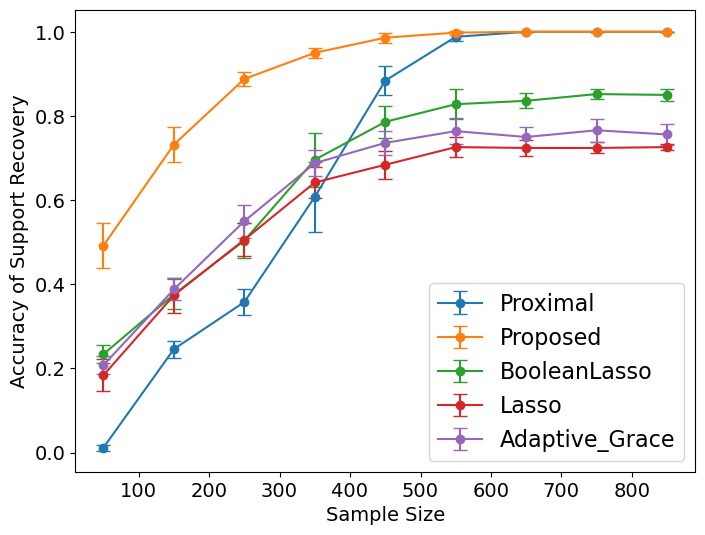

In [170]:
analysis(accuracy_41[:9], 41)

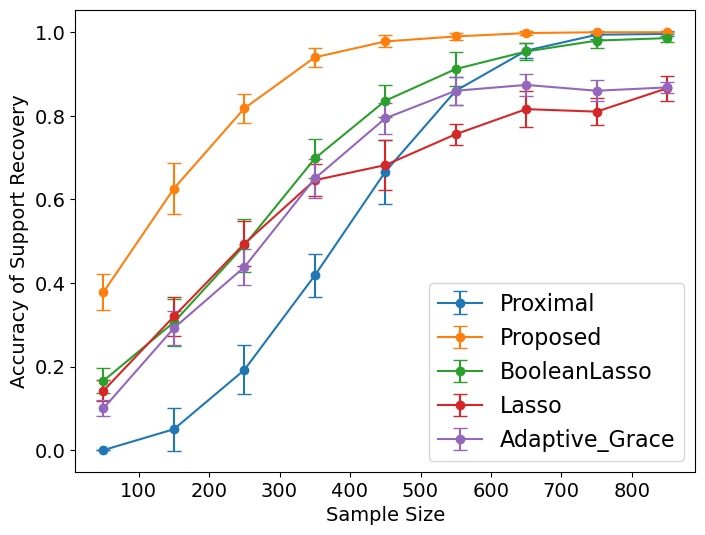

In [171]:
analysis(accuracy_51, 51)

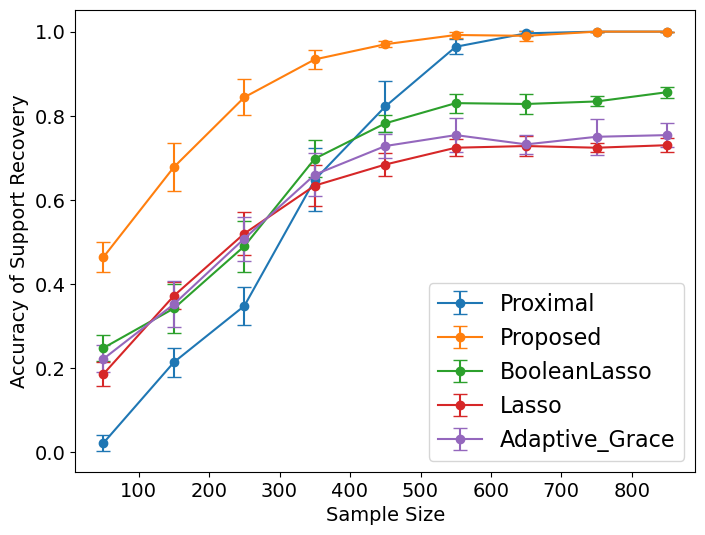

In [167]:
analysis(accuracy_77, 77)

In [172]:
accuracy_78= []
for n in sample_sizes:
    random_ensemble = RandomEnsembleCorrelationWeight(n=n, d=1000, k=50, 
                                     h_total=2, h_selected=1, h_rest=1, 
                                     gamma=0.5, p=0.7, q=0.2, 
                                     num_replications=5)
    accuracy_78.append(random_ensemble.main())

Synthetic dataset 1: Running GFL_Matlab model
Synthetic dataset 1: Running Lasso model
Synthetic dataset 1: Running Proximal model
1 3
Synthetic dataset 1: Running Lasso_Sklearn model
Synthetic dataset 1: Running Adaptive_Grace model
Synthetic dataset 2: Running GFL_Matlab model
Synthetic dataset 2: Running Lasso model
Synthetic dataset 2: Running Proximal model
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
Synthetic dataset 2: Running Lasso_Sklearn model
Synthetic dataset 2: Running Adaptive_Grace model
Synthetic dataset 3: Running GFL_Matlab model
Synthetic dataset 3: Running Lasso model
Synthetic dataset 3: Running Proximal model
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
Synthetic dataset 3: Running Lasso_Sklearn model
Synthetic dataset 3: Running Adaptive_Grace model
Synthetic dataset 4: Running GFL_Matlab model
Synthetic dataset 4: Running Lasso model
Synthetic dataset 4: Running Proximal model
1 3
Synthetic dataset 4: Running Lasso_Sklearn model
Synthetic dataset 4: Running Adaptive_

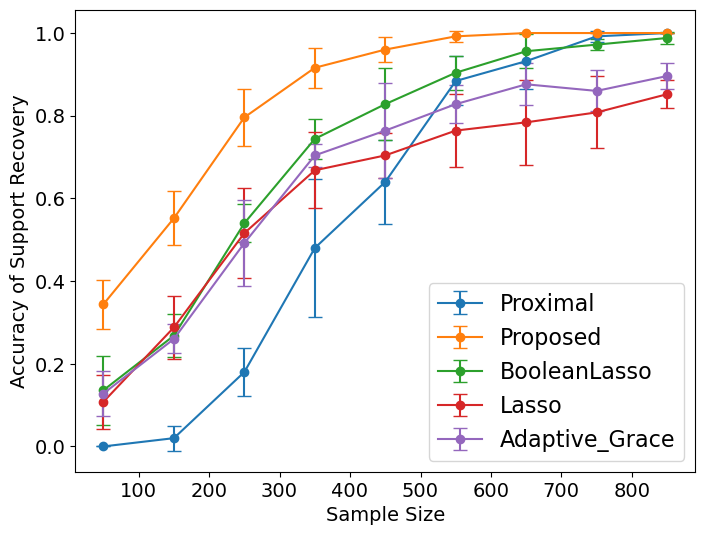

In [173]:
analysis(accuracy_78, 78)

# Section 2.3: Runtime comparison

In [ ]:
runtime = RandomEnsembleCorrelation(n=1000, d=1000, k=50, 
                                    h_total=2, h_selected=1, h_rest=1, 
                                    gamma=0.5, p=0.9, q=0.2, 
                                    num_replications=10)
runtime_results = runtime.runtime()

Running GFL_Matlab on replication 1/10...
rho: 31.622776601683793, mu: 0.01, acc: 1.0
rho: 31.622776601683793, mu: 0.1, acc: 1.0
rho: 31.622776601683793, mu: 1.0, acc: 0.9960000000000001
rho: 215.03488089144977, mu: 0.01, acc: 1.0
rho: 215.03488089144977, mu: 0.1, acc: 0.9960000000000001
rho: 215.03488089144977, mu: 1.0, acc: 0.9120000000000001
Best rho: 31.622776601683793, Best mu: 0.01
Running Lasso on replication 1/10...
Running Proximal on replication 1/10...
63 65
63 65
63 65
63 65
63 65
63 65
63 65
63 65
63 65
63 65
63 65
63 65
63 65
63 65
63 65
65 67
62 64
65 67
65 67
66 68
63 65
55 57
51 53
51 53
49 51
51 53
51 53
49 51
51 53
Running Lasso_Sklearn on replication 1/10...
Running Adaptive_Grace on replication 1/10...
Replication 1 completed.
Running GFL_Matlab on replication 2/10...
Running Lasso on replication 2/10...
Running Proximal on replication 2/10...
59 61
59 61
59 61
59 61
59 61
59 61
59 61
59 61
59 61
59 61
59 61
59 61
59 61
59 61
59 61
64 66
62 64
63 65
66 68
64 66
60 

In [ ]:
# Print runtime results
for model, (mean_time, std_time) in runtime_results.items():
    print(f"{model}: {mean_time:.2f} ± {std_time:.2f} seconds")

GFL_Matlab: 29.51 ± 61.11 seconds
Lasso: 8.53 ± 0.45 seconds
Proximal: 65.62 ± 21.66 seconds
Lasso_Sklearn: 0.05 ± 0.02 seconds
Adaptive_Grace: 121.67 ± 7.89 seconds


In [ ]:
runtime = RandomEnsembleCorrelation(n=1000, d=1000, k=50, 
                                    h_total=2, h_selected=1, h_rest=1, 
                                    gamma=0.5, p=0.9, q=0.2, 
                                    num_replications=10)
runtime_results = runtime.runtime()

Running GFL_Matlab on replication 1/10...
Running Lasso on replication 1/10...
Running Proximal on replication 1/10...
60 62
60 62
60 62
60 62
60 62
60 62
60 62
60 62
60 62
60 62
60 62
60 62
60 62
60 62
60 62
61 63
61 63
62 64
65 67
65 67
60 62
53 55
50 52
50 52
50 52
50 52
51 53
51 53
51 53
51 53
50 52
51 53
50 52
Running Lasso_Sklearn on replication 1/10...
Running Adaptive_Grace on replication 1/10...
Replication 1 completed.
Running GFL_Matlab on replication 2/10...
Running Lasso on replication 2/10...
Running Proximal on replication 2/10...
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
63 65
65 67
64 66
63 65
64 66
63 65
52 54
51 53
50 52
51 53
51 53
50 52
50 52
50 52
51 53
49 51
51 53
51 53
Running Lasso_Sklearn on replication 2/10...
Running Adaptive_Grace on replication 2/10...
Replication 2 completed.
Running GFL_Matlab on replication 3/10...
Running Lasso on replication 3/10...
Running Proximal on replication 3/10...
62 64
62 64
62 

In [ ]:
for model, (mean_time, std_time) in runtime_results.items():
    print(f"{model}: {mean_time:.2f} ± {std_time:.2f} seconds")

GFL_Matlab: 7.86 ± 0.37 seconds
Lasso: 8.40 ± 0.78 seconds
Proximal: 67.20 ± 28.56 seconds
Lasso_Sklearn: 0.06 ± 0.06 seconds
Adaptive_Grace: 133.91 ± 11.32 seconds


In [ ]:
runtime = RandomEnsembleCorrelation(n=1000, d=1000, k=50, 
                                    h_total=2, h_selected=1, h_rest=1, 
                                    gamma=0.5, p=0.9, q=0.2, 
                                    num_replications=30)
runtime_results = runtime.runtime()

Running GFL_Matlab on replication 1/30...
Running Lasso on replication 1/30...
Running Proximal on replication 1/30...
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
64 66
64 66
66 68
63 65
65 67
62 64
56 58
51 53
49 51
51 53
51 53
50 52
49 51
49 51
50 52
Running Lasso_Sklearn on replication 1/30...
Running Adaptive_Grace on replication 1/30...
Replication 1 completed.
Running GFL_Matlab on replication 2/30...
Running Lasso on replication 2/30...
Running Proximal on replication 2/30...
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
61 63
65 67
66 68
65 67
62 64
63 65
60 62
53 55
51 53
49 51
51 53
49 51
51 53
51 53
51 53
51 53
Running Lasso_Sklearn on replication 2/30...
Running Adaptive_Grace on replication 2/30...
Replication 2 completed.
Running GFL_Matlab on replication 3/30...
Running Lasso on replication 3/30...
Running Proximal on replication 3/30...
62 64
62 64
62 64
62 64
62 64
62 64
62 64
62 64
62 

In [ ]:
for model, (mean_time, std_time) in runtime_results.items():
    print(f"{model}: {mean_time:.2f} ± {std_time:.2f} seconds")

GFL_Matlab: 7.42 ± 0.99 seconds
Lasso: 8.02 ± 0.70 seconds
Proximal: 51.94 ± 27.03 seconds
Lasso_Sklearn: 0.04 ± 0.01 seconds
Adaptive_Grace: 126.27 ± 13.76 seconds
